In [1]:
from pytorch_grad_cam import CAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image as PilImage
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

from skimage.transform import resize
import random

import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
dir_path = '../Peliculas_New/'

In [4]:
def get_dataframe(path):
    videos = []
    labels = []
    for folder in os.listdir(path):
        # print(folder)
        fd = dir_path + folder + '/'
        # print(fd)
        for video in os.listdir(fd):
            vd = os.path.join(fd, video)
            # print(vd)
            i = 1 if folder == 'fights' else 0
            videos.append(vd)
            labels.append(i)
    data_dict = {
        'videos': videos,
        'labels': labels 
    }
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

In [5]:
df = get_dataframe(dir_path)
df.head(), df.tail()

(                                 videos  labels
 0    ../Peliculas_New/fights/newfi1.avi       1
 1   ../Peliculas_New/fights/newfi10.avi       1
 2  ../Peliculas_New/fights/newfi100.avi       1
 3   ../Peliculas_New/fights/newfi11.avi       1
 4   ../Peliculas_New/fights/newfi12.avi       1,
                                videos  labels
 195  ../Peliculas_New/noFights/95.mpg       0
 196  ../Peliculas_New/noFights/96.mpg       0
 197  ../Peliculas_New/noFights/97.mpg       0
 198  ../Peliculas_New/noFights/98.mpg       0
 199  ../Peliculas_New/noFights/99.mpg       0)

In [6]:
def capture(filename, timesep, rgb, h, w):
    tmp = []
    frames = np.zeros((timesep, rgb, h, w), dtype=float)
    i=0
    vc = cv2.VideoCapture(filename)
    if vc.isOpened():
        rval , frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        rval = False
    frm = resize(frame, (h, w, rgb))
    frm = np.expand_dims(frm, axis=0)
    frm = np.moveaxis(frm, -1, 1)
    if(np.max(frm) > 1):
        frm = frm / 255.0
    frames[i][:] = frm
    i += 1
    while i < timesep:
        tmp[:] = frm[:]
        rval, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frm = resize(frame,( h, w, rgb))
        frm = np.expand_dims(frm, axis=0)
        if(np.max(frm) > 1):
            frm = frm / 255.0
        frm = np.moveaxis(frm, -1, 1)
        frames[i-1][:] = frm
        i +=1
    return frames.astype(np.float32)

In [7]:
from torch.utils.data import Dataset 

class VideoDataset(Dataset):

    def __init__(self, datas, timesep=40, rgb=3, h=160, w=160):
        self.dataloctions = datas
        self.timesep, self.rgb, self.h, self.w = timesep, rgb, h, w

    def __len__(self):
        return len(self.dataloctions)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        video = capture(self.dataloctions.iloc[idx, 0], self.timesep, self.rgb, self.h, self.w)
        sample = {'video': torch.from_numpy(video), 'label': torch.from_numpy(np.asarray(np.float32(self.dataloctions.iloc[idx, 1])))}
        return sample

In [8]:
dataset = VideoDataset(df)
len(dataset)

200

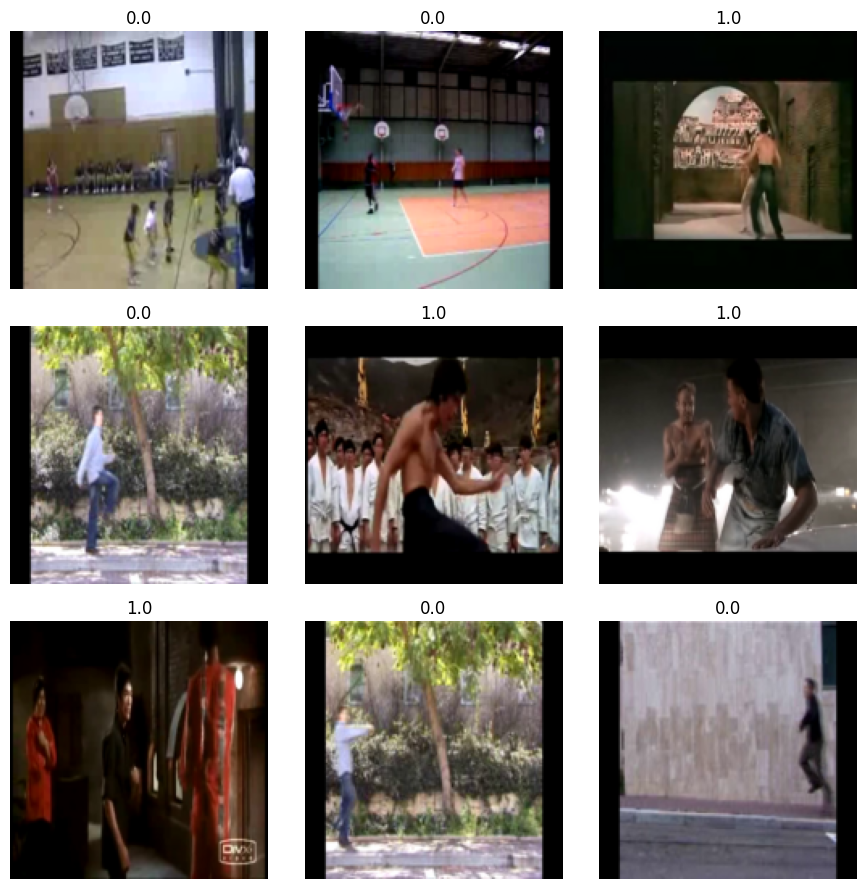

In [9]:
r, c = 3, 3
fig = plt.figure(figsize=(3*c, 3*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset)-1)
        img, label = dataset[ix]['video'], dataset[ix]['label'].item()
        img = img[0].permute(1, 2, 0)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title(label)
plt.tight_layout()
plt.show()

In [10]:
class TimeWarp(nn.Module):
    def __init__(self, baseModel, method='squeeze'):
        super(TimeWarp, self).__init__()
        self.baseModel = baseModel
        self.method = method

    def forward(self, x):
        batch_size, time_steps, C, H, W = x.size()
        if self.method == 'loop':
            output = []
            for i in range(time_steps):
                #input one frame at a time into the basemodel
                x_t = self.baseModel(x[:, i, :, :, :])
                # Flatten the output
                x_t = x_t.view(x_t.size(0), -1)
                output.append(x_t)
            #end loop
            #make output as  ( samples, timesteps, output_size)
            x = torch.stack(output, dim=0).transpose_(0, 1)
            output = None # clear var to reduce data  in memory
            x_t = None  # clear var to reduce data  in memory
        else:
            # reshape input  to be (batch_size * timesteps, input_size)
            x = x.contiguous().view(batch_size * time_steps, C, H, W)
            x = self.baseModel(x)
            x = x.view(x.size(0), -1)
            #make output as  ( samples, timesteps, output_size)
            x = x.contiguous().view(batch_size , time_steps , x.size(-1))
        return x

In [11]:
class extractlastcell(nn.Module):
    def forward(self,x):
        out , _ = x
        return out[:, -1, :]

In [12]:
# Create model
num_features = 12800
rnn_hidden_size = 30
rnn_num_layers = 2
dr_rate= 0.2
num_classes = 1

ResNet50 = models.resnet50(pretrained=True)
custom_RN50 = nn.Sequential()
ct = 0
for child in ResNet50.children():
    if ct < 5:
        custom_RN50.append(child)
        for param in child.parameters():
            param.requires_grad = False
    elif ct == 5:
        custom_RN50.append(child)
        for param in child.parameters():
            param.requires_grad = True
    else:
        break
    ct += 1
custom_RN50.append(nn.AdaptiveAvgPool2d(output_size=(5, 5)))

model = nn.Sequential(
        TimeWarp(custom_RN50),
        nn.Dropout(dr_rate),
        nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers , batch_first=True),
        extractlastcell(),
        nn.Linear(30, 256),
        nn.ReLU(),
        nn.Dropout(dr_rate),
        nn.Linear(256, num_classes)
    )
checkpoint = torch.load('../weights/best_model_custom.pth')
model.load_state_dict(checkpoint)

c:\Users\CV\miniconda3\envs\torch_cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\CV\miniconda3\envs\torch_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [13]:
idx = 86
vid = capture(df.iloc[idx, 0], 40, 3, 160, 160)
print(vid.shape, vid.max(), vid.min())

(40, 3, 160, 160) 1.0 0.0


In [14]:
img = vid[0].transpose(1, 2, 0)
print(img.shape, img.max(), img.min())

(160, 160, 3) 0.9998768 0.0


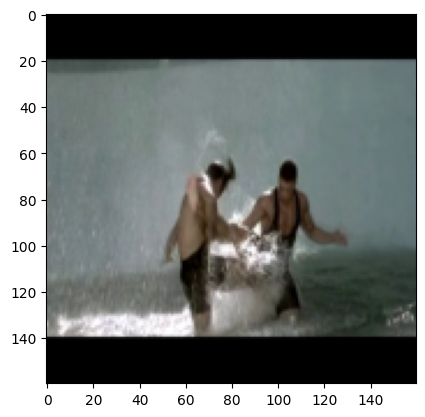

In [15]:
plt.imshow(img)
plt.show()

In [16]:
in_model = model[0].baseModel
target_layer = model[0].baseModel[5][-1]
method = "gradcam++" # Can be gradcam/gradcam++/scorecam
input_tensor = torch.tensor(vid)
cam = CAM(model=in_model, target_layer=target_layer, use_cuda=False)
grayscale_cam = cam(input_tensor=input_tensor, target_category=1, method=method)
visualization = show_cam_on_image(img, grayscale_cam)

c:\Users\CV\miniconda3\envs\torch_cuda\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


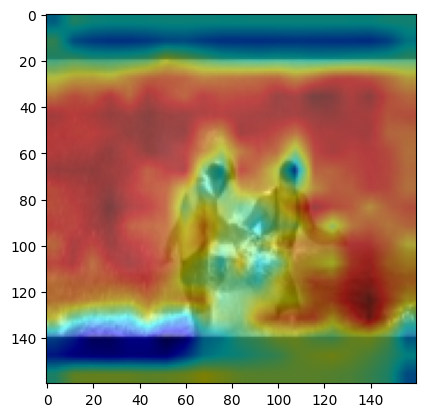

In [17]:
plt.imshow(visualization)
plt.show()